In [1]:
import warnings

import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

plt.style.use("bmh")
az.rcParams["stats.hdi_prob"] = 0.89

warnings.simplefilter('ignore', category=FutureWarning)

/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
ucbadmit = pd.read_csv('Data/UCBadmit.csv', sep=';')

In [3]:
gid, gender = pd.factorize(ucbadmit['applicant.gender'])

In [4]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0, 1, shape=2)
    p = pm.math.invlogit(a[gid])
    admit = pm.Binomial('admit', p=p, 
                        n=ucbadmit.applications.values, 
                        observed=ucbadmit.admit.values)
    idata11_1 = pm.sample()
    pp11_1 = pm.sample_posterior_predictive(idata11_1, var_names=['a'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [5]:
idata11_1.posterior['da'] = idata11_1.posterior['a'].sel(a_dim_0=0) - idata11_1.posterior['a'].sel(a_dim_0=1)
az.summary(idata11_1, var_names=['a', 'da'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.220,0.039,-0.282,-0.160,0.001,0.000,3474.0,2835.0,1.0
a[1],-0.829,0.050,-0.903,-0.743,0.001,0.001,3493.0,2582.0,1.0
da,0.609,0.063,0.509,0.706,0.001,0.001,3551.0,2578.0,1.0


Text(0, 0.5, 'Density')

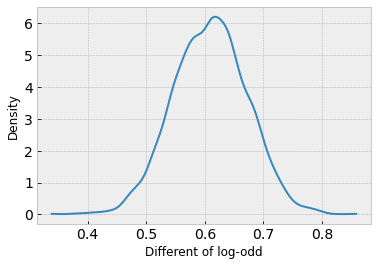

In [6]:
az.plot_kde(idata11_1.posterior['da'].stack(sample=('chain', 'draw')).values)
plt.xlabel("Different of log-odd")
plt.ylabel("Density")

In [7]:
with pm.Model() as m12_1:
    phi = pm.Exponential('phi', 1.0)
    theta = pm.Deterministic('theta', phi+2.0)
    a = pm.Normal('a', 0, 1, shape=2)
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[gid]))
    A = pm.BetaBinomial('Admit', pbar*theta, (1-pbar)*theta, 
                        ucbadmit.applications.values, observed=ucbadmit.admit.values)
    idata12_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [8]:
idata12_1.posterior['da'] = idata12_1.posterior['a'].sel(a_dim_0=0) - idata12_1.posterior['a'].sel(a_dim_0=1)
az.summary(idata12_1, var_names=['a', 'phi', 'theta', 'da'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.411,0.387,-1.018,0.217,0.007,0.005,3452.0,2515.0,1.0
a[1],-0.296,0.401,-0.921,0.342,0.008,0.006,2603.0,2185.0,1.0
phi,1.044,0.796,0.008,2.088,0.015,0.011,1947.0,1308.0,1.0
theta,3.044,0.796,2.008,4.088,0.015,0.011,1947.0,1308.0,1.0
da,-0.114,0.554,-0.963,0.798,0.010,0.009,3040.0,2818.0,1.0


<AxesSubplot:>

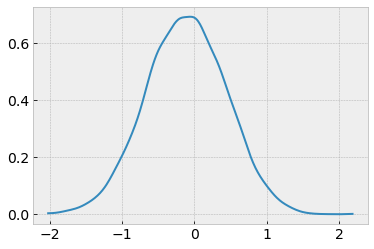

In [9]:
az.plot_kde(idata12_1.posterior['da'].stack(sample=('chain', 'draw')).values)

Text(0.5, 1.0, 'Distribution of female admission rates')

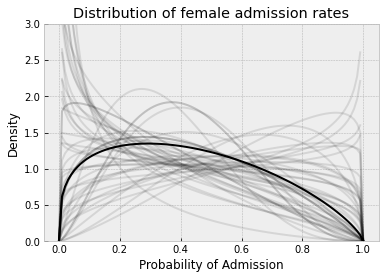

In [10]:
x_plot = np.linspace(0,1,100)
pbar_mean = special.expit(idata12_1.posterior.a.sel(a_dim_0=1)).mean()
theta_mean = idata12_1.posterior.theta.mean()
plt.plot(x_plot, stats.beta.pdf(x_plot, pbar_mean*theta_mean, 
                                (1-pbar_mean)*theta_mean), c='k')
a1_50samples = idata12_1.posterior.a[0,:50,1]
p1_50 = special.expit(a1_50samples)
theta_50samples = idata12_1.posterior.theta[0,:50]
plt.plot(x_plot, 
         stats.beta.pdf(x_plot[:, np.newaxis], p1_50*theta_50samples, (1-p1_50)*theta_50samples), 
         c='k', alpha=0.1)
plt.xlabel("Probability of Admission")
plt.ylim(0,3)
plt.ylabel("Density")
plt.title("Distribution of female admission rates")

In [11]:
with m12_1:
    ppc = pm.sample_posterior_predictive(idata12_1, var_names=['pbar', 'Admit'])
pbar_post = ppc.posterior_predictive.pbar
pp_admit = ppc.posterior_predictive.Admit / ucbadmit.applications.values

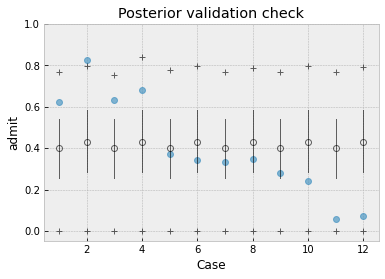

In [12]:
plt.plot(range(1, 13), ucbadmit.admit / ucbadmit.applications, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), pbar_post.mean(dim=['chain', 'draw']), "ko", 
         fillstyle="none", ms=6, alpha=0.6)
plt.plot(np.tile(range(1,13), (2,1)), az.hdi(pbar_post).pbar.T, "k-", lw=1, alpha=0.6)
plt.plot(np.tile(range(1,13), (2,1)), az.hdi(pp_admit).Admit.T, "k+", lw=1, alpha=0.6)
plt.xlabel("Case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-.05, 1);

In [13]:
## MONK DATA
prob_drink = 0.2
rate_work = 1
N = 365
drink = np.random.binomial(1, prob_drink, size=N)
y = (1-drink)*np.random.poisson(rate_work, size=N)

Text(0, 0.5, 'Frequency')

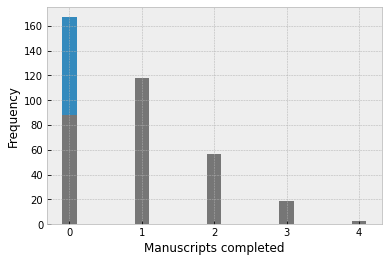

In [14]:
no_drink = drink.sum()
zero_work = (y==0).sum() - no_drink
bins = np.arange(y.max()+1)-0.5
plt.hist(y, bins=bins, rwidth=0.2, color='k', alpha=0.5)
plt.bar(0, no_drink, bottom=zero_work, width=0.2)
plt.xlabel("Manuscripts completed")
plt.ylabel("Frequency")

In [15]:
print(no_drink / N, zero_work / N, special.logit(no_drink/N))

0.21643835616438356 0.2410958904109589 -1.286543958352831


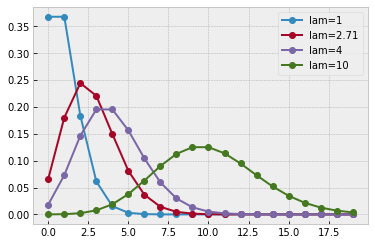

In [16]:
x = np.arange(0, 20)
for lam in [1,2.71,4,10]:
    plt.plot(x, stats.poisson.pmf(x, lam), 'o-', label=f'lam={lam}')
plt.legend()

In [17]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.2, 1.0)
    al = pm.Normal("al", 1.0, .5)
    p = pm.math.invlogit(ap)
    lam = pm.math.exp(al)
    y_obs = pm.ZeroInflatedPoisson("y", 1.0-p, lam, observed=y)
    id12_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ap, al]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [18]:
az.summary(id12_3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ap,-1.957,0.499,-2.659,-1.208,0.014,0.010,1233.0,1553.0,1.0
al,-0.020,0.082,-0.153,0.102,0.002,0.002,1161.0,1066.0,1.0


In [19]:
special.expit(id12_3.posterior.ap.mean()), np.exp(id12_3.posterior.al.mean())

(<xarray.DataArray 'ap' ()>
 array(0.12383768),
 <xarray.DataArray 'al' ()>
 array(0.980258))

In [4]:
trolley = pd.read_csv("Data/Trolley.csv", sep=';')
trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


Text(0, 0.5, 'frequency')

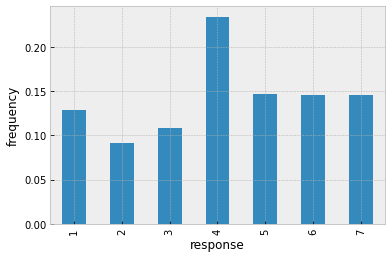

In [13]:
trolley.response.value_counts(normalize=True, sort=False).sort_index().plot(kind='bar')
plt.xlabel("response")
plt.ylabel("frequency")

In [6]:
lco = trolley.response.value_counts(normalize=True, sort=False)\
             .sort_index().cumsum().apply(special.logit)
lco.round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

In [63]:
cutpoints_prior = special.logit(np.linspace(0,1,8)[1:-1])
with pm.Model() as m12_4:
    bA = pm.Normal('bA', 0, 0.5)
    bI = pm.Normal('bI', 0, 0.5)
    bC = pm.Normal('bC', 0, 0.5)
    A = pm.Data("A", trolley.action.values)
    I = pm.Data("I", trolley.intention.values)
    C = pm.Data("C", trolley.contact.values)
    phi = pm.Deterministic('phi', bA*A + bI*I + bC*C)
    cutpoints = pm.Normal('cutpoints', cutpoints_prior, 1.5)
    R = pm.OrderedLogistic('R', phi, cutpoints, compute_p=False, observed=trolley.response.values-1)
    id12_4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, bI, bC, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.


In [64]:
az.summary(id12_4)

/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/telescreen/miniconda3/

KeyboardInterrupt: 

trolley.groupby(['action', 'intention', 'contact']).response\
       .value_counts(normalize=True, sort=False)\
       .unstack().cumsum(axis=1).round(3)

In [47]:
case_df = pd.DataFrame(
    np.array([[0,0,0],[0,0,1],[1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=['action', 'contact', 'intention']
)
case_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [ ]:
with m12_4:
    pm.set_data({
        'A': case_df.action.values,
        'I': case_df.intention.values,
        'C': case_df.contact.values
    })
    pp_phi = pm.sample_posterior_predictive(id12_4, var_names=['phi'])